# ⚽ Análisis de Estadísticas de Partidos de Fútbol con Pandas

Este notebook utiliza Pandas para el análisis de datos de fútbol.

In [ ]:
# Instalar dependencias
!pip install pyspark pandas matplotlib

In [2]:
# Importar dependencias

# OS
import os

# Spark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

# Pandas
import pandas as pd

# Importar Matplotlib
import matplotlib.pyplot as plt

In [ ]:
# Lectura variables de entorno
TOP_TEAMS_TO_DISPLAY = int(os.getenv("TOP_TEAMS_TO_DISPLAY", 5))
TOP_SCORERS_TO_DISPLAY = int(os.getenv("TOP_SCORERS_TO_DISPLAY", 5))
MINUTE_SEGMENTS = int(os.getenv("MINUTE_SEGMENTS", 15))

# Imprimir variables de entorno
print ("Variables de entorno:")
print ("\t- TOP_TEAMS_TO_DISPLAY: ", TOP_TEAMS_TO_DISPLAY)
print ("\t- TOP_SCORERS_TO_DISPLAY: ", TOP_SCORERS_TO_DISPLAY)
print ("\t- MINUTE_SEGMENTS: ", MINUTE_SEGMENTS)

Variables de entorno:
	- TOP_TEAMS_TO_DISPLAY:  10
	- TOP_SCORERS_TO_DISPLAY:  15
	- MINUTE_SEGMENTS:  20


In [ ]:
# Creación de la sesión de Spark
spark = (SparkSession.builder
    .appName("Soccer Analytics")
    .getOrCreate())

---

## 🥅 Goleadores por Partido (`goalscorers.csv`)

### Carga inicial

In [6]:
# Definición del esquema para goleadores
scorersSchema = StructType([
    StructField("date", DateType(), False),
    StructField("home_team", StringType(), False),
    StructField("away_team", StringType(), False),
    StructField("team", StringType(), False),
    StructField("scorer", StringType(), False),
    StructField("minute", IntegerType(), True),
    StructField("own_goal", StringType(), True),
    StructField("penalty", StringType(), True)
])

# Carga del DataFrame de Goleadores
scorers_df = (spark.read.option("header", "true")
              .option("dateFormat", "yyyy-MM-dd")
              .csv("goalscorers.csv", schema=scorersSchema)
             )

### Exploración inicial

In [7]:
scorers_df.show(5, truncate=False)

+----------+--------------+-----------------+-----------------+-----------+------+--------+-------+
|date      |home_team     |away_team        |team             |scorer     |minute|own_goal|penalty|
+----------+--------------+-----------------+-----------------+-----------+------+--------+-------+
|2023-08-12|Manchester Utd|Wolves           |Manchester Utd   |Rashford M.|15    |NULL    |NULL   |
|2023-08-12|Arsenal       |Nottingham Forest|Arsenal          |Saka B.    |8     |NULL    |NULL   |
|2023-08-12|Arsenal       |Nottingham Forest|Nottingham Forest|Awoniyi T. |42    |NULL    |NULL   |
|2023-08-12|Arsenal       |Nottingham Forest|Arsenal          |Odegaard M.|78    |NULL    |NULL   |
|2023-08-12|Chelsea       |Liverpool        |Chelsea          |Sterling R.|25    |NULL    |NULL   |
+----------+--------------+-----------------+-----------------+-----------+------+--------+-------+
only showing top 5 rows



### Goles por equipo
Cálculo de goles por equipo (excluyendo goles en propia puerta)

In [8]:
# Agrupamos por equipo y contamos cuántos goles han marcado,
# filtrando previamente los goles en propia puerta para no alterar el dato real de goles a favor
goals_by_team = (
    scorers_df
        .filter(col("own_goal").isNull())
        .groupBy("team")
        .agg(count("*").alias("goals"))
        .orderBy(desc("goals"))
)

# Mostrar los equipos con más goles
goals_by_team.limit(TOP_TEAMS_TO_DISPLAY).show()

+----------------+-----+
|            team|goals|
+----------------+-----+
|          France|   28|
|        Portugal|   26|
|       Argentina|   19|
|          Brazil|   14|
|         Germany|   12|
|    FC Barcelona|   12|
| Manchester City|   11|
|   Bayern Munich|   10|
|        Paris SG|   10|
|Bayer Leverkusen|   10|
+----------------+-----+



### Top goleadores
Cálculo del top de goleadores (excluyendo goles en propia puerta)

In [9]:
# Agrupamos por jugador y contamos cuántos goles han marcado,
# filtrando previamente los goles en propia puerta para no alterar el dato real de goles a favor
top_scorers = (
    scorers_df
        .filter(col("own_goal").isNull())
        .groupBy("scorer")
        .agg(count("*").alias("goals"))
        .orderBy(desc("goals"))
)

# Mostrar los máximos goleadores
top_scorers.limit(TOP_SCORERS_TO_DISPLAY).show()

+----------------+-----+
|          scorer|goals|
+----------------+-----+
|       Mbappe K.|   14|
|      Ronaldo C.|   11|
|         Kane H.|    8|
|      Joao Felix|    7|
|    Griezmann A.|    7|
|    Vinicius Jr.|    6|
|Lautaro Martinez|    6|
|    Fernandes B.|    6|
|      Musiala J.|    5|
|     Gundogan I.|    5|
|        Messi L.|    5|
|      Haaland E.|    5|
|   Bellingham J.|    5|
|       Giroud O.|    5|
|      Neymar Jr.|    5|
+----------------+-----+



### Distribución de goles por tramos de partido
Cálculo de goles por los tramos en minutos de partido (excluyendo goles en propia puerta)

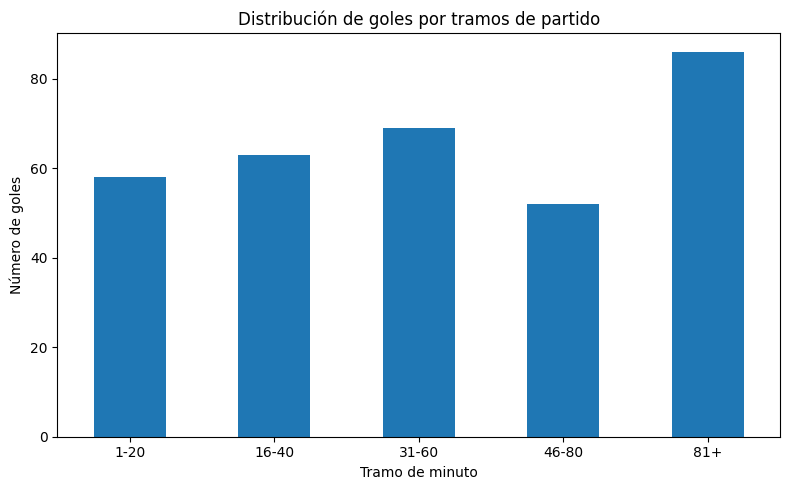

In [10]:
# Contar goles por tramo, excluyendo goles en propia puerta
goals_by_bin_spark = (
    scorers_df
    .filter(col("own_goal").isNull()) # Excluimos goles en propia puerta
    .withColumn("minute_bin_idx", (col("minute") / MINUTE_SEGMENTS).cast("int")) # Bloque de 15 en 15: 0,1,2,3,...
    .groupBy("minute_bin_idx")
    .agg(count("*").alias("goals"))
    .orderBy("minute_bin_idx")
)

# Pasamos el resultado a pandas
goals_by_bin_pd = goals_by_bin_spark.toPandas()

# Creamos etiquetas bonitas para el eje X
minutes = {
    idx: (
        f"{idx * MINUTE_SEGMENTS + 1}+"
        if idx == goals_by_bin_pd["minute_bin_idx"].max()
        else f"{idx * 15 + 1}-{(idx + 1) * MINUTE_SEGMENTS}"
    )
    for idx in range(goals_by_bin_pd["minute_bin_idx"].max() + 1)
}

goals_by_bin_pd["minute_bin"] = goals_by_bin_pd["minute_bin_idx"].map(minutes)
goals_by_bin_pd = goals_by_bin_pd.set_index("minute_bin")

# Pintar gráfico
plt.figure(figsize=(8, 5))
goals_by_bin_pd["goals"].plot(kind="bar")

plt.xlabel("Tramo de minuto")
plt.ylabel("Número de goles")
plt.title("Distribución de goles por tramos de partido")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()